## ==The Start==

In [1]:
from __future__ import unicode_literals
import gym
import gym_gridworld

import optuna
import random
import openpyxl
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

<Figure size 432x288 with 0 Axes>

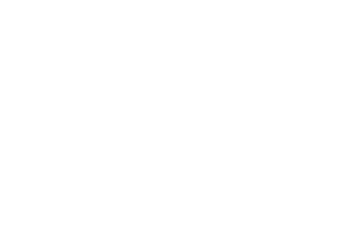

In [4]:
env = gym.make('gridworld-v0')

## Q-Network

In [5]:
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden1, hidden2): # state가 인풋, 그에 대한 Q값 계산이 아웃풋
        super(QNetwork, self).__init__()
        self.layer1 = nn.Sequential(
                                    nn.Linear(input_size, hidden1),
                                    nn.ReLU())
                                    
        self.layer2 = nn.Sequential(
                                    nn.Linear(hidden1, hidden2),
                                    nn.ReLU() )

        self.layer3 = nn.Sequential(    nn.Linear(hidden2, output_size)  )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x) #            tensor([ 0.0757, -0.0513], grad_fn=) 형태의 출력이 나옴.
#                                        torch.float32
        return x

## Replay Buffer

In [6]:
class ReplayBuffer:

    # state, action, 등 별로 저장 할 빈 array 생성
    def __init__(self, obs_dim, act_dim, buff_size):        # obs_dim=4, act_dim=1, size=100_000
        self.state_buff = np.zeros([buff_size, obs_dim])    # 아래에 np.zeros() 설명 참조 [64, 4]
        self.action_buff = np.zeros([buff_size, 1])
        self.reward_buff = np.zeros([buff_size, 1], dtype=np.float32)
        self.next_state_buff = np.zeros([buff_size, obs_dim])
        self.done_buff = np.zeros([buff_size, 1], dtype=np.float32)


        # self.state의 경우, [64, 4]의 크기인데, state 하나는 [0.3233, 2.3241, -0.3233, -2.3241]의 형태로 생겼음.
        # 저 state 하나를 저장하면, (0,0)에 저장되는 게 아니라, component 별로 한 행에 다 들어감.
        # 그래서 64 샘플에 대해 64개 행이 생김.
        
        self.ptr = 0 # 새 experience가 저장될 위치를 가리킴.
        self.size = 0
        self.max_size = buff_size

    def store(self, state, action, reward, next_state, done): # np.ndarray 형태로 저장

        self.state_buff[self.ptr] = state   # 저장되는 방식은 아래 np.zeros() 설명 참조
        self.action_buff[self.ptr] = action
        self.reward_buff[self.ptr] = reward
        self.next_state_buff[self.ptr] = next_state
        self.done_buff[self.ptr] = done
        
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        idx= np.random.randint(0, self.size, size=batch_size) # 랜덤하게 experience를 뽑아옴

        return dict(state=torch.tensor(self.state_buff[idx], dtype=torch.float32), # NN에 넣을 때 torch.float32 형이어야 함.
                    action=torch.tensor(self.action_buff[idx], dtype=torch.long),
                    reward=torch.tensor(self.reward_buff[idx], dtype=torch.float32),
                    next_state=torch.tensor(self.next_state_buff[idx], dtype=torch.float32),
                    done=torch.tensor(self.done_buff[idx]))  # 사용할 때는 key로 인덱싱 해서 불러올 거임.

## Agent

In [7]:
class Agent:
    def __init__(self, init_eps, min_eps, eps_decay, gamma, target_update_freq,
                qnet, target_qnet, optimizer, criterion):

        # eps는 사실 attribute로 안 만들고 'get_action'에서 바로 써도 되는데
        # Hyperparameter Tuning할 거라서 이렇게 씀
        self.init_eps = init_eps #0.9
        self.min_eps = min_eps #0.05
        self.eps = self.init_eps
        self.eps_decay = eps_decay
        self.timer = 0

        self.gamma = gamma
        self.target_update_freq = target_update_freq

        self.qnet = qnet
        self.target_qnet = target_qnet
        self.optimizer = optimizer
        self.criterion = criterion
        
    # action은 0 또는 1의 scalar로 반환 할 거임
    def get_action(self, state, step):
        self.timer += 1
        self.eps = self.min_eps + (self.init_eps - self.min_eps) * np.exp(-1. * self.timer / self.eps_decay)

        # 처음에는 eps_threshold가 큰 값이라 else에서만 작동함
        if random.random() > self.eps:
            action = self.qnet(state).detach().squeeze().numpy().argmax(axis=0)
            return int(action)

        else:
            action = env.action_space.sample()
            return action



    def learn(self, batch, current_epi):
        state = batch['state'] # tensor([[-1.0468, -0.8232,  1.4239,  0.4460],
        #                                [-8.8516e-01,  4.3342e-02,  1.6168e+00, -7.7498e-01], .......


        action = batch['action'] # tensor([[1], 
        #                                  [0], 
        #                                  [0], 

        reward = batch['reward'] # tensor([[1.],
        #                                  [1.],
        #                                  [1.],

        next_state = batch['next_state'] # state와 같음

        done = batch['done'] #tensor([[0.],
        #                             [0.],
        #                             [0.],


        # Q(S,A)에 해당하는 부분임.
        # Q값은 ANN으로 예측한 건데, 그 중에서 실제로 했던 action을 gather 활용해 찾음.
        # dim=1이니까 0열과 1열 중에서 index에 맞는 것들을 골라올 거임
        current_q = self.qnet(state).gather(dim=1, index=action) # tensor([[0.3761],
        #                                                                  [0.3822],
        #                                                                  [0.3724],....... grad_fn=)

        # max Q(S',A')에 해당하는 부분임.
        # 각 행마다 0과 1에 대하여 Q값이 나왔는데, dim=1이니까 max에 해당하는 열만 뽑아옴
        next_q = self.target_qnet(next_state).max(dim=1)[0].reshape(-1, 1)#tensor([[0.3761],
        #                                                                          [0.3822],
        #                                                                          [0.3724],....... grad_fn=)

        # R + gamma * max Q(S',A')
        td_target = reward + self.gamma * next_q * (1-done)

        # td_error = td_target - current_q
        loss = self.criterion(current_q, td_target)

        self.optimizer.zero_grad()
        loss.backward()

        # Q(S,A) <---- Q(S,A) + alpha*[R + gamma*max Q(S',A') - Q(S,A)]
        self.optimizer.step()


        if current_epi % self.target_update_freq == 0:
            self.target_qnet.load_state_dict(self.qnet.state_dict())

## 각종 설정

In [9]:
# 각종 설정
max_epi = 600
reward_per_epi = []  # 에피소드마다 보상값 저장
step_per_epi_list = []  # 에피소드마다 스텝 수 저장

# Environment 관련
obs_dim = 16*16 #env.observation_space.shape[0]
act_dim = 5 #env.action_space.n

# Network 관련                                        🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
qnet = QNetwork(input_size=obs_dim, output_size=act_dim, hidden1=256, hidden2=256) # state 넣어서, 각 action에 대한 Q값 출력
target_qnet = QNetwork(input_size=obs_dim, output_size=act_dim, hidden1=256, hidden2=256)
target_qnet.load_state_dict(qnet.state_dict())

optimizer = optim.RAdam(qnet.parameters(), lr=1e-4) #🔥🔥🔥🔥🔥🔥🔥
criterion = nn.MSELoss()

# Replay Buffer 관련
memory = ReplayBuffer(obs_dim, act_dim, buff_size=100_000)

# Agent 관련                                               🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
agent = Agent(init_eps=0.9, min_eps=0.05, eps_decay=200, gamma=0.95, target_update_freq=4,
                qnet=qnet, target_qnet=target_qnet, optimizer=optimizer, criterion=criterion)


#🔥🔥겜 관련 설정🔥🔥
max_epi = 500
reward_per_epi_list = []  # 에피소드마다 보상값 저장
step_per_epi_list = []  # 에피소드마다 스텝 수 저장

## 학습 시작

In [10]:
''' state 형태 ---> (16, 16),  <class 'numpy.ndarray'>
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [1 0 3 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 2 0 0 0 1 0 0 0 0 0 0 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
'''
print()

In [ ]:
for episode in range(1, max_epi+1): # 에피소드 단위

    # 방금 막 받은 state는 numpy.ndarray
    state = env.reset() 
    state = np.ravel(state)


    done = False

    step_per_epi = 0   # 에피소드마다 step 얼마나 버티나 추적할 거임
    reward_per_epi = 0 # 에피소드마다 cumulative reward를 추적할 거임

    while not done: # step 단위

        env.render()

        # action은 Env.에 직접 전달할 값이므로 Normalization하면 안 됨
        action = agent.get_action(torch.tensor(state, dtype=torch.float32),  #   1   //// 
                                step=step_per_epi)

        print(action)

        env_info = env.step(action)

        next_state = env_info[0]
        next_state = np.ravel(next_state)

        reward = env_info[1] # 1.0 //// 

        done = env_info[2]

        memory.store(state, action, reward, next_state, done)


        if memory.size >= 200: #🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
            batch = memory.sample(batch_size=32) # 꺼내온 batch는 전부 tensor 형태로 구성됨
            agent.learn(batch, current_epi=episode)

        reward_per_epi += reward
        step_per_epi += 1

        state = next_state 


    reward_per_epi_list.append(reward_per_epi) # 에피소드마다 끝나고 최종 얻은 누적 reward 저장
    step_per_epi_list.append(step_per_epi) # 에피소드마다 끝나고 최종 얻은 step 저장

    if episode % 20 == 0:
        print(f'Episode: {episode},  Avg.Rewards: {np.mean(reward_per_epi_list[-100:])},  Avg.Steps: {np.mean(step_per_epi_list[-100:])},\
            Epsilon: {agent.eps}')

    #if np.mean(reward_per_epi_list[-100:]) >= 2000:
    #    print(f'Environment solved in {episode} episodes!')
    #    break


env.close()

## ==The End==